In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [17]:
## funções auxiliares
def dB(x):
    "Converte escalar para dB"
    return 10 * np.log10(x)


def dBm(x):
    "Converte escalar para dB"
    return 10 * np.log10(x / 0.001)


def escalar(x):
    "Converte dB para escalar"
    return 10 ** (int(x) / 10)


def LogDistancia(d, PRd0, d0, n):
    "Modelo de perda de percurso logaritmica"
    logd = PRd0 - 10 * n * np.log10(d / d0)
    return dBm(logd)

In [18]:
def tratar_dados(data_txt):
    data = pd.read_csv(
        data_txt,
        sep="|",
        header=None,
        encoding="utf-8",
        names=["data", "n", "id", "mensagem", "medida"],
    )
    data = data[pd.to_numeric(data["medida"], errors="coerce").notnull()]
    data = data[
        data["mensagem"].isin(
            [
                " 1metros ",
                " 10metros ",
                " 20metros ",
                " 30metros ",
                " 40metros ",
                " 50metros ",
                " 60metros ",
                " 70metros ",
                " 80metros ",
                " 90metros ",
                " 100metros ",
            ]
        )
    ]
    data["medida"] = data["medida"].apply(escalar)
    return data


def media_das_medidas(data):
    data["medida"] = data["medida"].astype(str)
    data["medida"] = data["medida"].str.replace(" metros", "")
    data["medida"] = data["medida"].str.replace(" ", "")
    data["medida"] = data["medida"].astype(float)
    data = data["medida"].mean()
    return data


def plot_dados(data, media):
    media = dBm(media)
    plt.figure(figsize=(10, 6))
    sns.histplot(data["medida"], kde=True)
    plt.axvline(media, color="r", linestyle="--", label=f"Mean: {media:.2f}")
    plt.legend()
    plt.title(f"Media das medidas: {media}")
    plt.show()


def process(data):
    data = tratar_dados(data)
    mean = media_das_medidas(data)
    data["medida"] = data["medida"].apply(dBm)
    plot_dados(data, mean)

    return mean

In [25]:
# Função para processar e plotar os dados em subplots
def process_and_plot(arquivos_medidas):
    num_files = len(arquivos_medidas)
    num_cols = 2
    num_rows = (num_files + 1) // num_cols

    # Definir o tamanho da figura para corresponder ao tamanho de uma folha A4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8.27, 11.69), dpi=300)
    axes = axes.flatten()

    all_data = pd.DataFrame()

    for i, file in enumerate(arquivos_medidas):
        data = tratar_dados(file)
        mean = dBm(media_das_medidas(data))
        dist = file.split("_")[1].split(".")[0]

        sns.histplot(dBm(data["medida"]), kde=True, ax=axes[i])
        axes[i].axvline(mean, color="r", linestyle="--", label=f"Mean: {mean:.2f}")
        axes[i].legend(fontsize="small")
        axes[i].set_title(f"Media das medidas de {dist}: {mean}", fontsize="small")

        # Adicionar os dados processados ao DataFrame
        all_data = pd.concat(
            [all_data, pd.DataFrame({"file": [file], "mean": [mean]})],
            ignore_index=True,
        )

    # Remover subplots vazios
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar layout para caber na folha A4
    plt.tight_layout()

    # Salvar a figura como um arquivo PDF
    plt.savefig("grafico_medias.pdf")

    # Mostrar a figura
    plt.show()

    return all_data

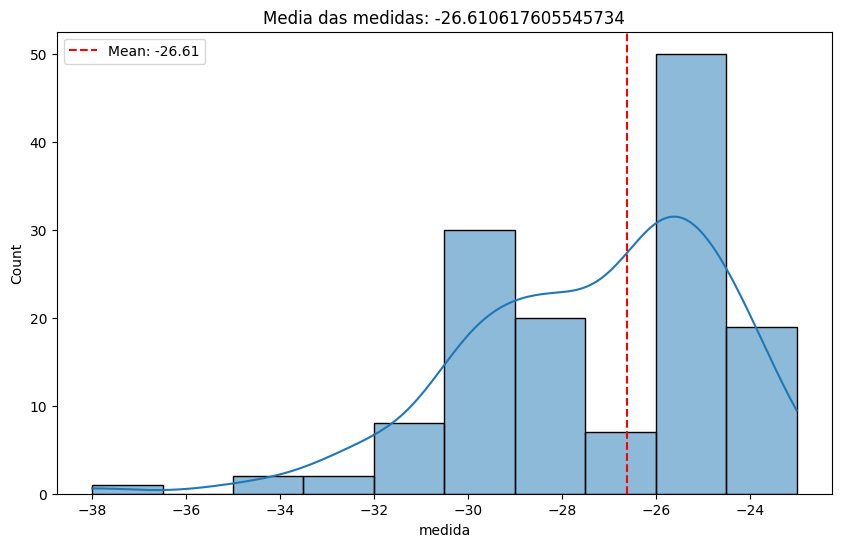

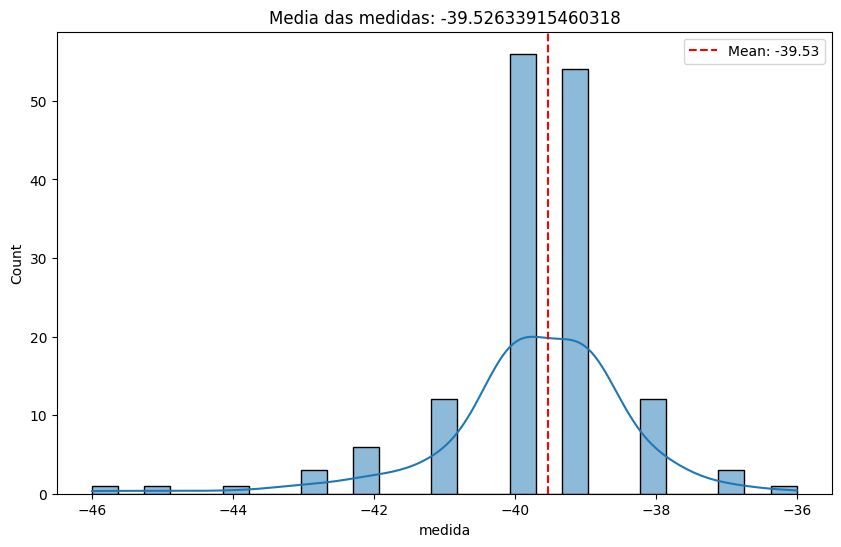

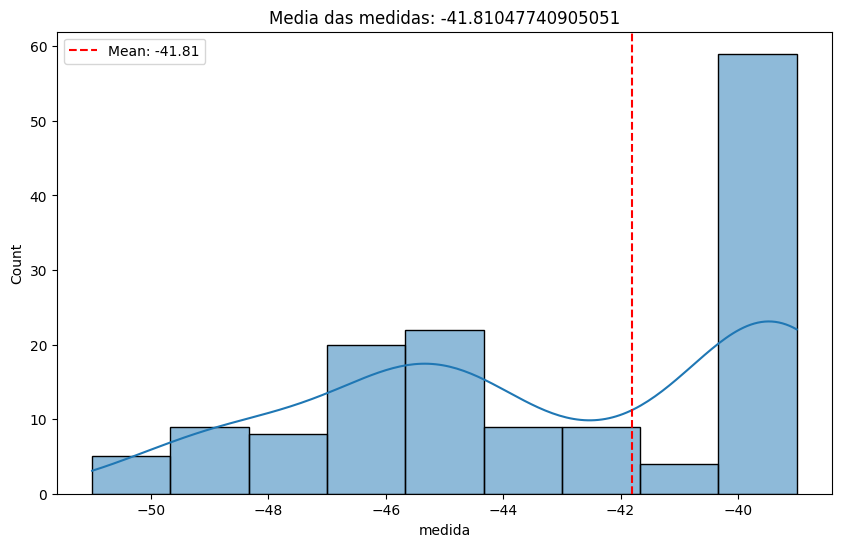

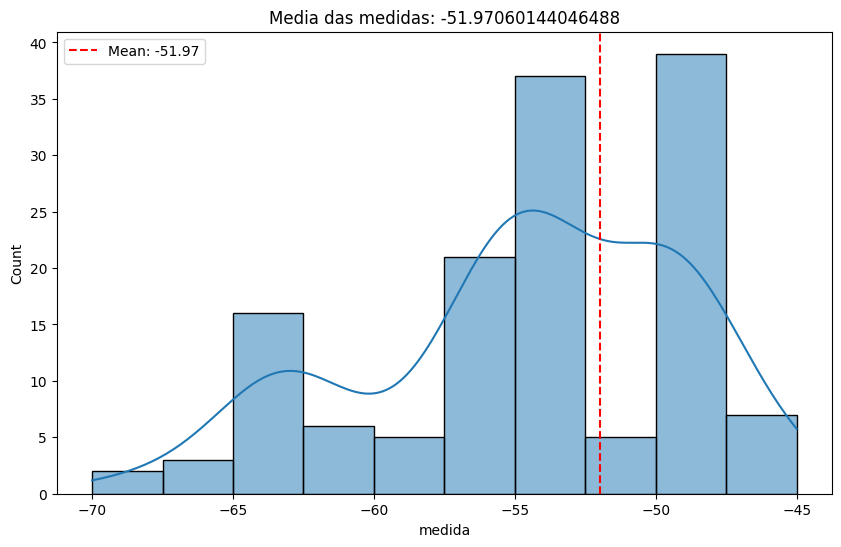

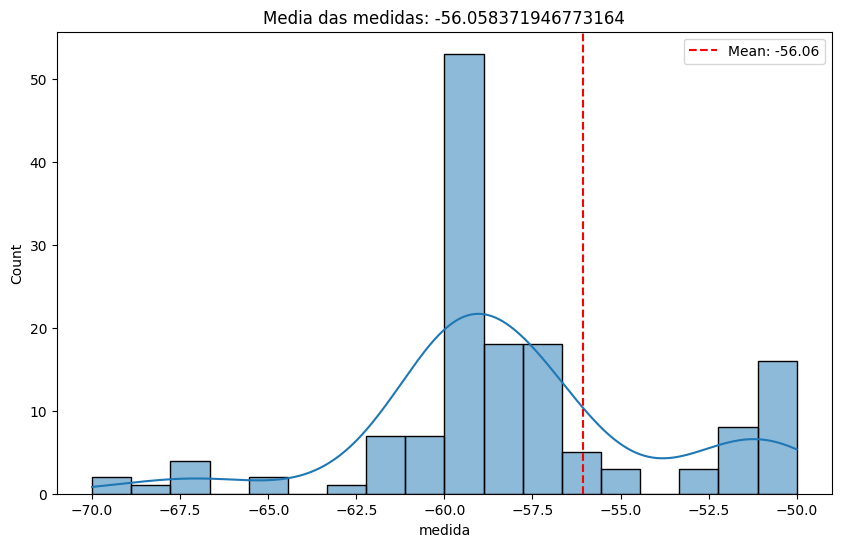

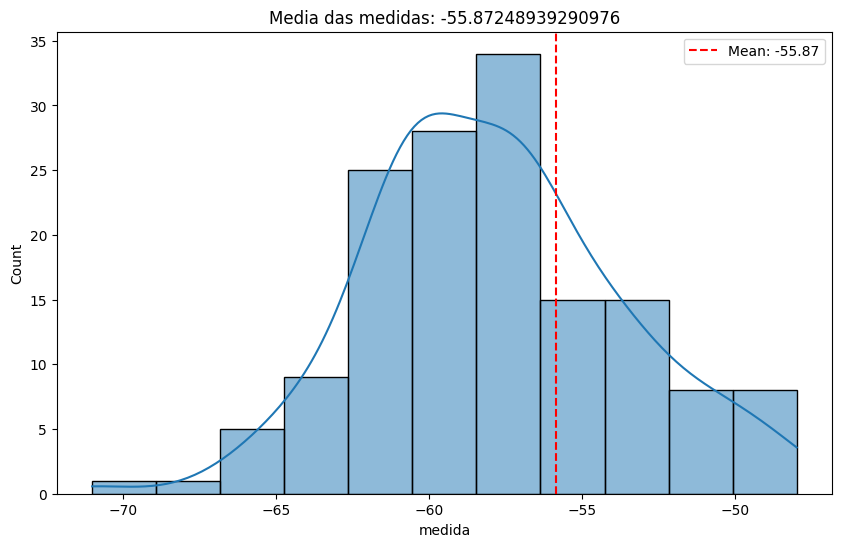

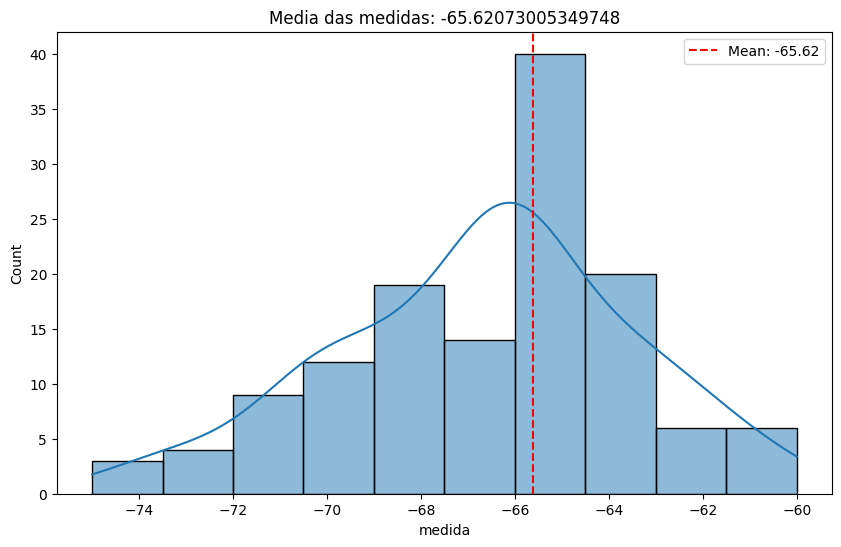

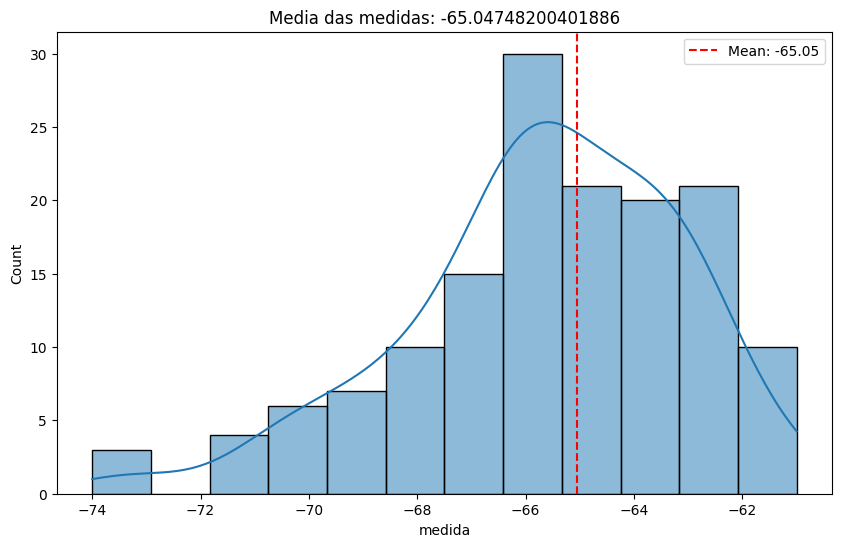

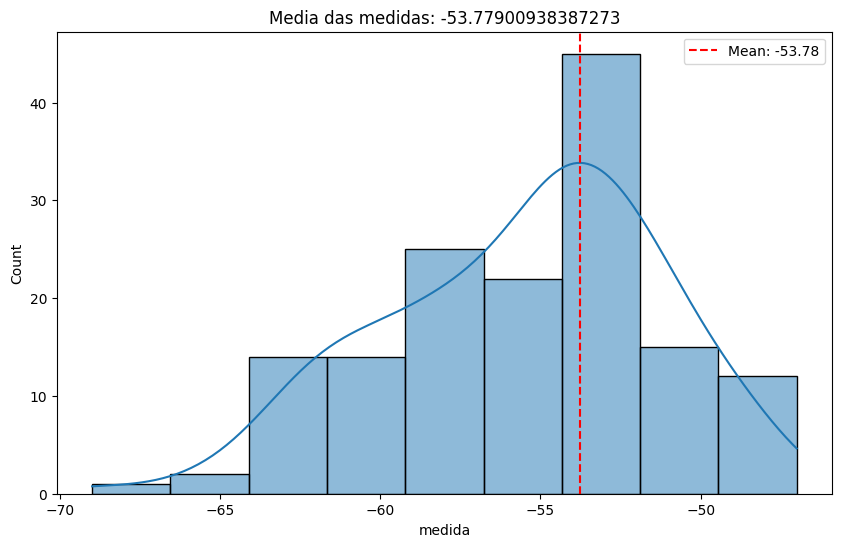

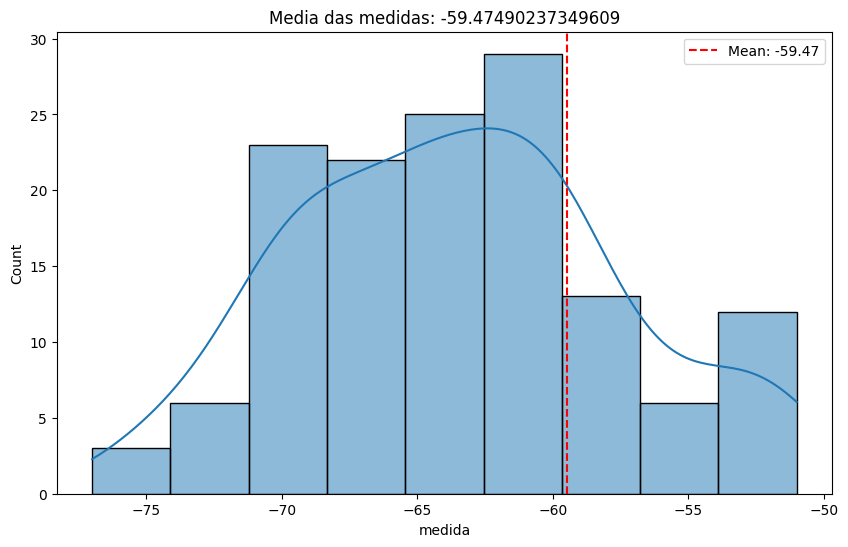

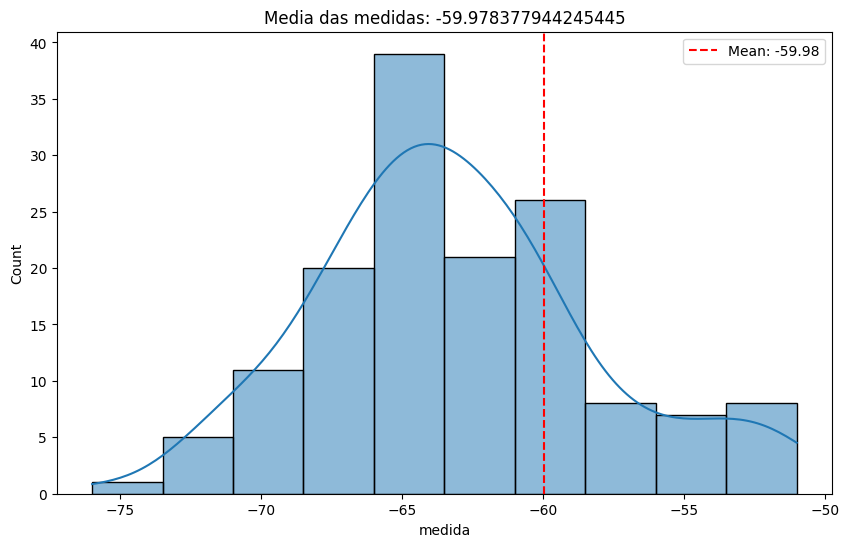

In [23]:
arquivos_medidas = [
    "medida_01m.txt",
    "medida_10m.txt",
    "medida_20m.txt",
    "medida_30m.txt",
    "medida_40m.txt",
    "medida_50m.txt",
    "medida_60m.txt",
    "medida_70m.txt",
    "medida_80m.txt",
    "medida_90m.txt",
    "medida_100m.txt",
]

media_medidas = [process(data) for data in arquivos_medidas]

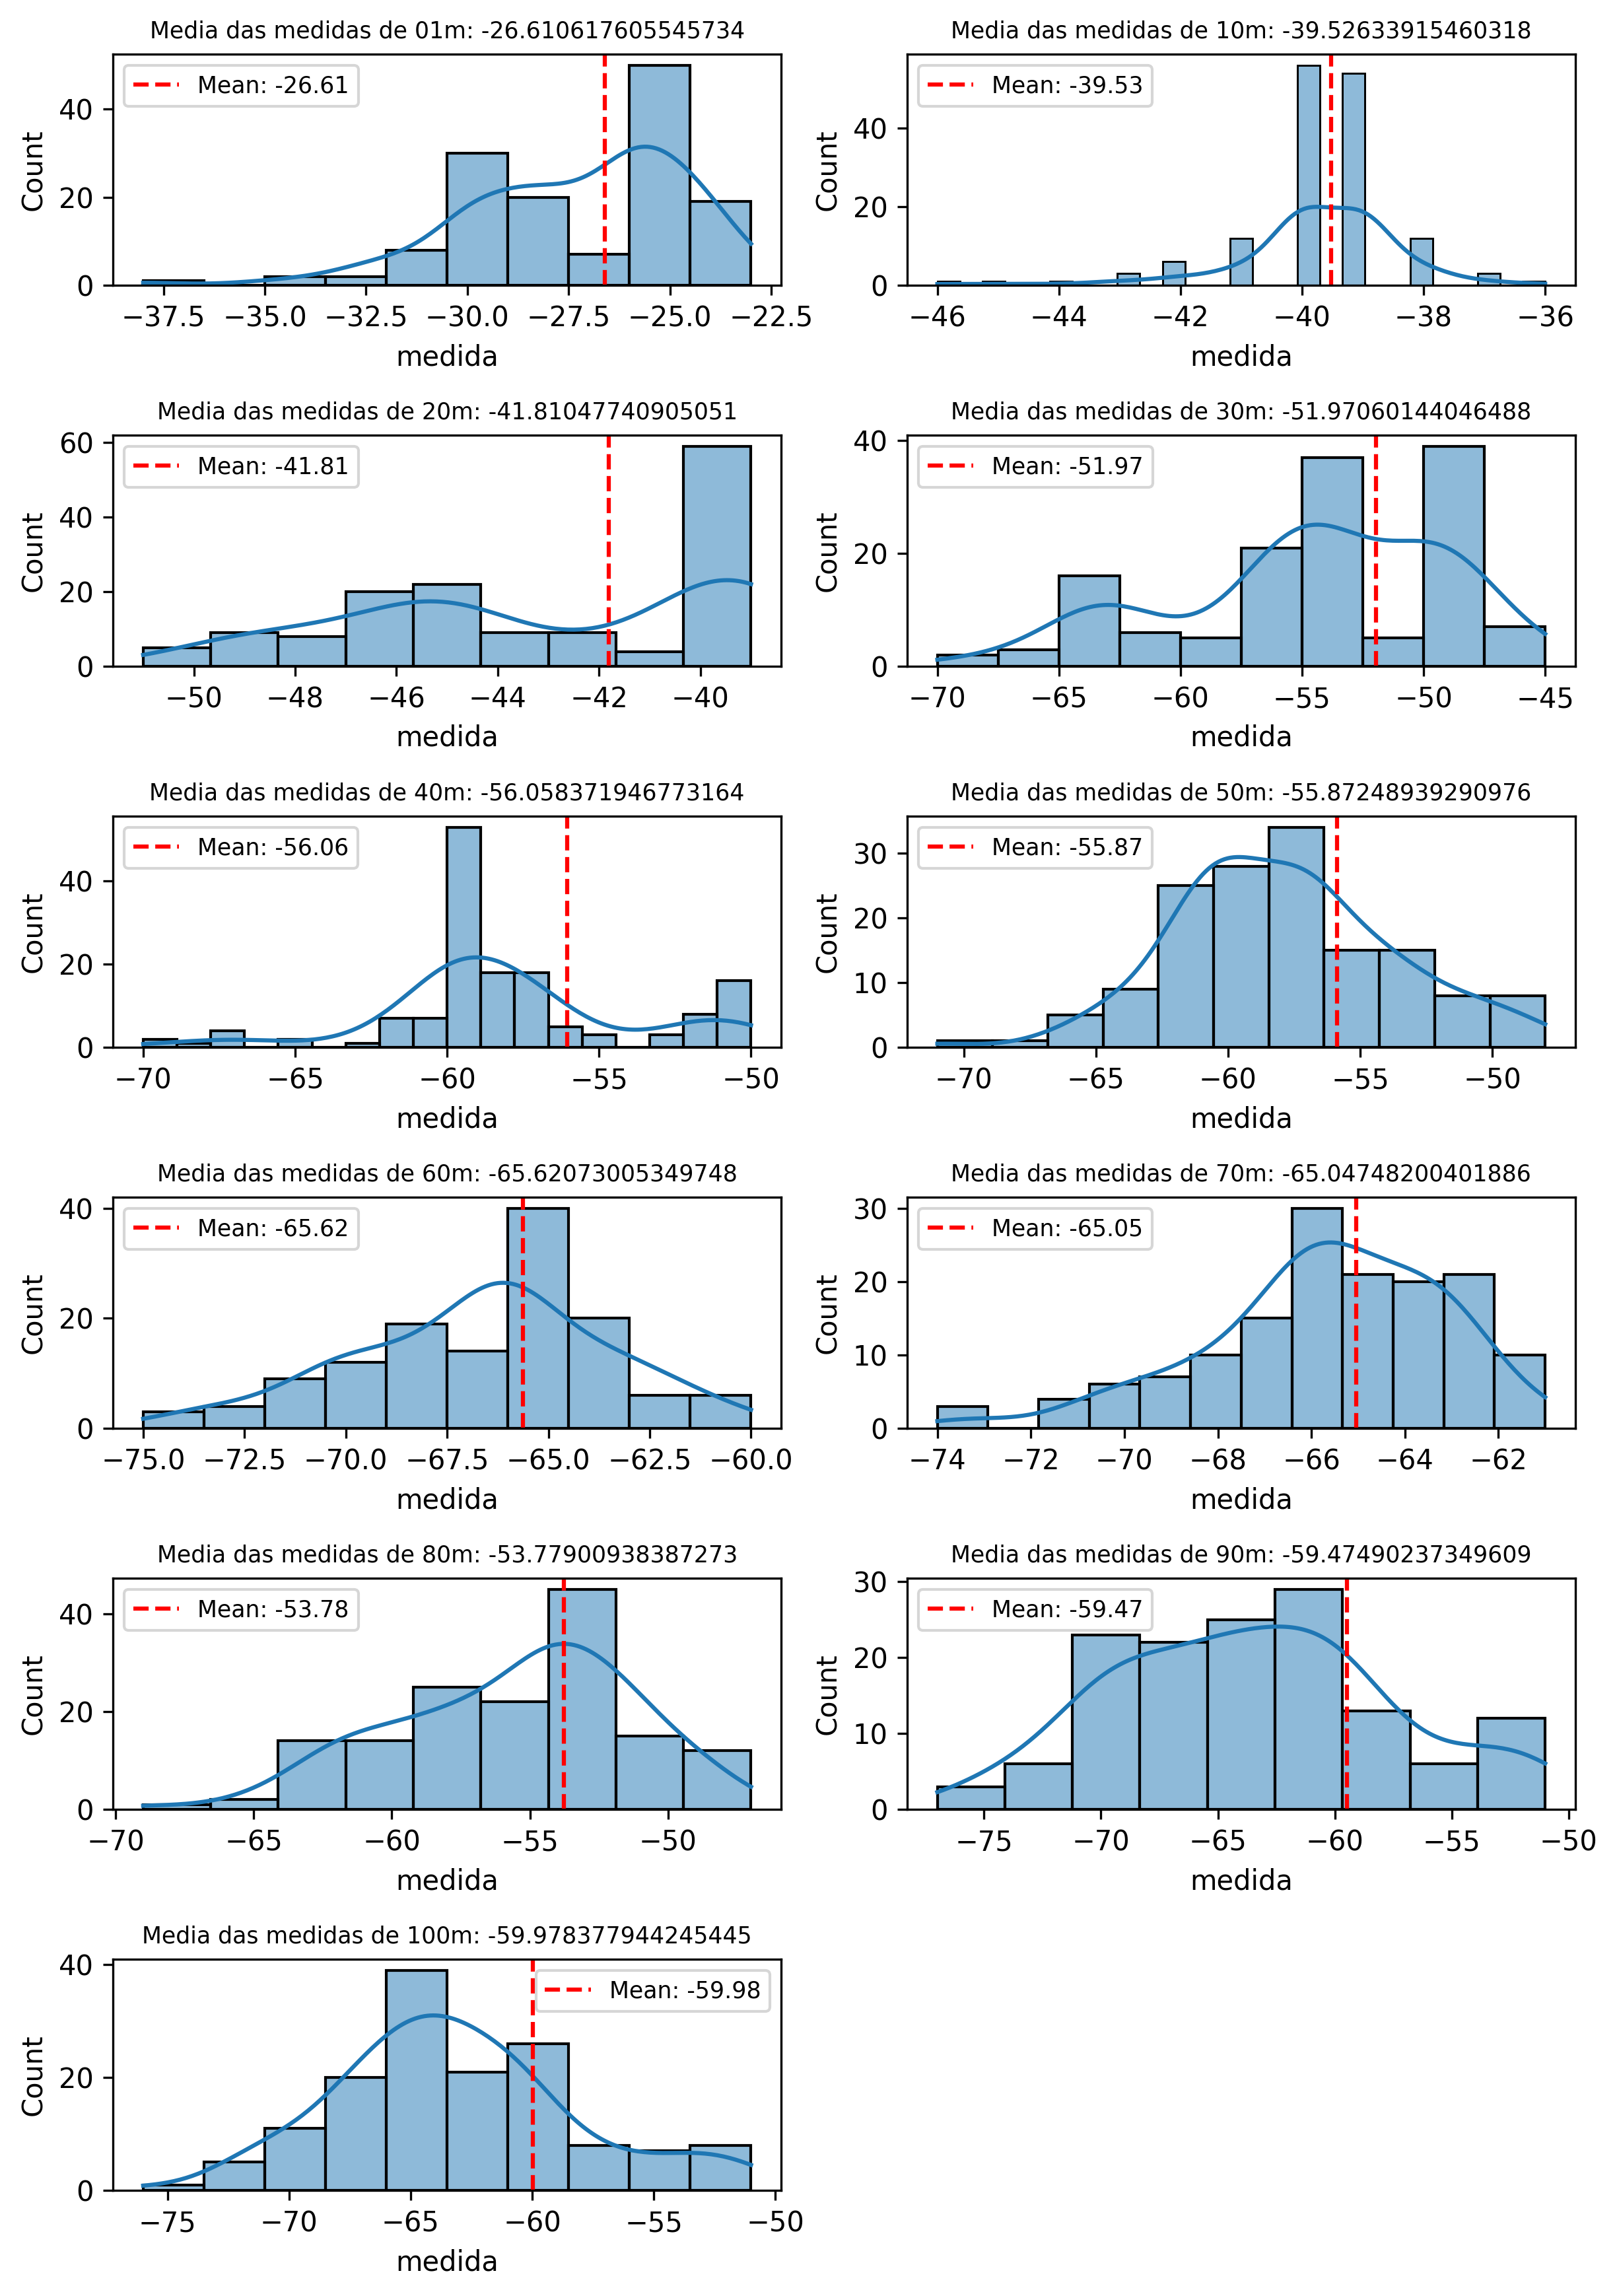

In [26]:
all_data = process_and_plot(arquivos_medidas)

In [28]:
media_medidas = pd.DataFrame(dBm(media_medidas), columns=["Média"])
distancias = np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
media_medidas["Distância"] = distancias
media_medidas

,Média,Distância
0,-26.610618,1
1,-39.526339,10
2,-41.810477,20
3,-51.970601,30
4,-56.058372,40
5,-55.872489,50
6,-65.620730,60
7,-65.047482,70
8,-53.779009,80
9,-59.474902,90


In [29]:
TX = 14  # dBm
fc = 915 * 10**6  # Hz

distancia = np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
pr_medido = np.array(media_medidas["Média"])

Valor ótimo de n: 1.7293


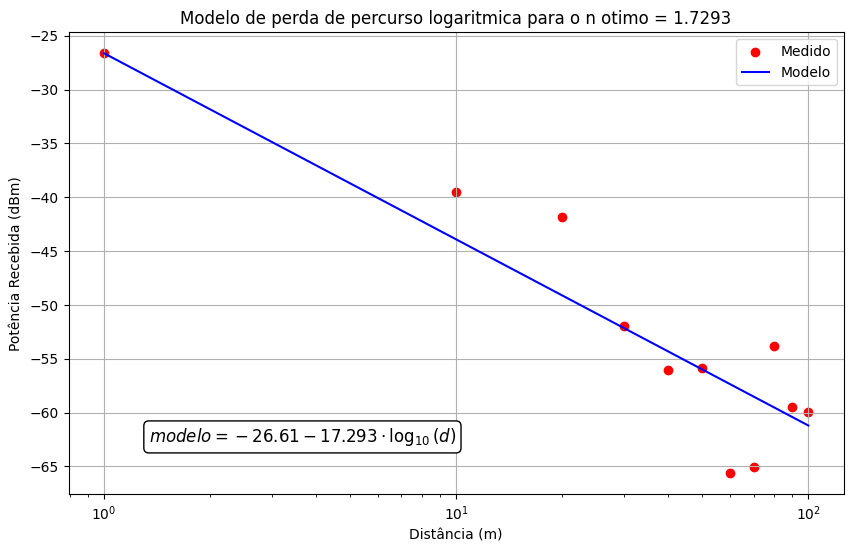

In [33]:
def calcular_modelo(distancias, pr_medido, p0=pr_medido[0]):
    def erro_quadratico(n, distancia, pr_medido, p0):
        pr_modelo = p0 - 10 * n * np.log10(distancia)
        return np.sum((pr_medido - pr_modelo) ** 2)

    # Minimizar a função erro_quadratico para encontrar o valor de n que minimiza o erro
    resultado = minimize(erro_quadratico, x0=[2], args=(distancias, pr_medido, p0))

    # Valor ótimo de n
    n_otimo = resultado.x[0]

    # Calcular o modelo com o valor ótimo de n
    d_modelo = np.linspace(1, 100, 100)
    modelo = p0 - 10 * n_otimo * np.log10(d_modelo)

    # Exibir os resultados
    print(f"Valor ótimo de n: {n_otimo:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(distancias, pr_medido, label="Medido", color="red")
    plt.plot(d_modelo, modelo, label="Modelo", color="blue")
    plt.legend()
    plt.xlabel("Distância (m)")
    plt.ylabel("Potência Recebida (dBm)")
    plt.annotate(
        r"$modelo = -26.61 - 17.293 \cdot \log_{10}(d)$",
        xy=(0.5, 0.1),
        xycoords="axes fraction",
        fontsize=12,
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round", fc="w"),
    )
    plt.title(f"Modelo de perda de percurso logaritmica para o n otimo = {n_otimo:.4f}")
    plt.xscale("log")
    plt.grid(True)
    plt.savefig("modelo_Larga_escala.pdf")
    plt.show()

    return n_otimo, modelo


# Chamar a função com os dados disponíveis
n_otimo, modelo = calcular_modelo(distancias, pr_medido)